# Imports

In [3]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from scipy.optimize import minimize

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')

In [14]:
c = [['a', _] for _ in np.random.normal(.01, .1,10_000)]
for _ in np.random.normal(.013, .1,10_000): c.append(['b', _]) 
for _ in np.random.normal(.008, .1,10_000): c.append(['c', _]) 
for _ in np.random.normal(.006, .1,10_000): c.append(['d', _])

df = pl.DataFrame(c)

def get_max(a, b, c, d):
    rdf = df.groupby('column_0').agg([pl.mean('column_1')])
    return rdf

get_max(0, 0, 0, 0)

column_0,column_1
str,f64
"""d""",0.006171
"""c""",0.087142
"""a""",0.010445
"""b""",0.011705


In [39]:
cov = np.array([[1, .0, .0, .01],\
                [0, 1,  0, -.02],\
                [0, 0,  1,  .01],\
                [.01, -.02, .01,1]])
cov
data = np.random.multivariate_normal(mean=[.01, .013, .008, .0], cov=cov, size=(10_000))#, columns=['a', 'b', 'c', 'd']
idx = np.arange(10_000).reshape(-1,1)
data = np.concatenate((data, idx), axis=1)
df = pl.DataFrame(data, columns=['a', 'b', 'c', 'd', 'idx'])

df.head()
# def get_max(a, b, c, d):
#     rdf = df.groupby('column_0').agg([pl.mean('column_1')])
#     return rdf

/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_46824/3496815302.py:9: DeprecationWarning: `columns` is deprecated as an argument to `__init__`; use `schema` instead.
  df = pl.DataFrame(data, columns=['a', 'b', 'c', 'd', 'idx'])


a,b,c,d,idx
f64,f64,f64,f64,f64
0.40617,0.278073,-0.814642,0.535278,0.0
2.566749,-0.984793,-1.072249,-0.403729,1.0
0.799448,1.044163,0.920203,0.239521,2.0
-0.142499,-0.147592,1.080262,-1.056162,3.0
-0.340187,2.188484,0.853299,1.454854,4.0


In [52]:
w = np.array([[10,200,3000,40000]]) 
# w*df[:,:4]
(w.T * df[:,:4]).mean(axis=1)

np.linalg.lstsq(df[:,:4].to_numpy(),df[:,4].to_numpy())[0]

/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_46824/2575058923.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(df[:,:4].to_numpy(),df[:,4].to_numpy())[0]


SeriesView([ 38.47500951, -48.22933574,   6.07912189, -53.34757217])


b = [[  -10.28762925    35.41826033  -216.23980489   647.6106599
  -1013.53843739   784.03625675  -237.11388234]]
mse: 2.227482e-02
mae: 9.942065e-02
----------------------------------------------------------------

(10000, 1)


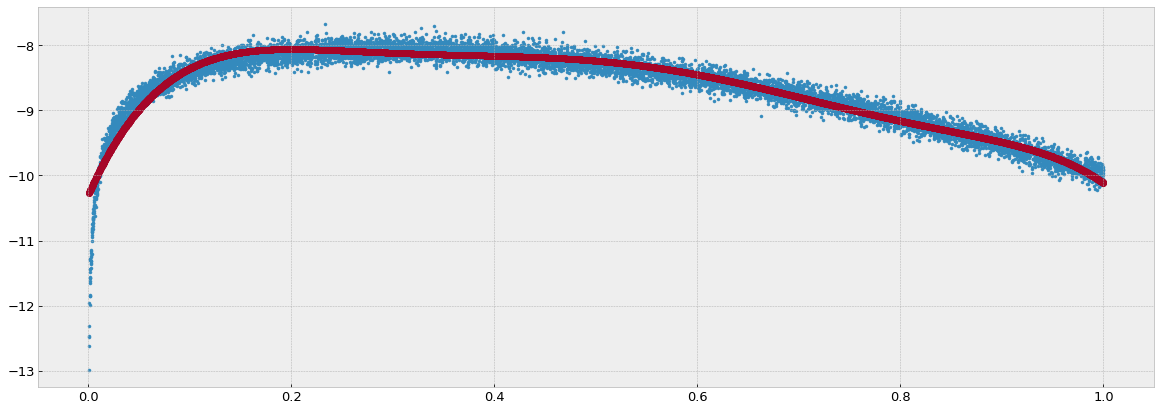

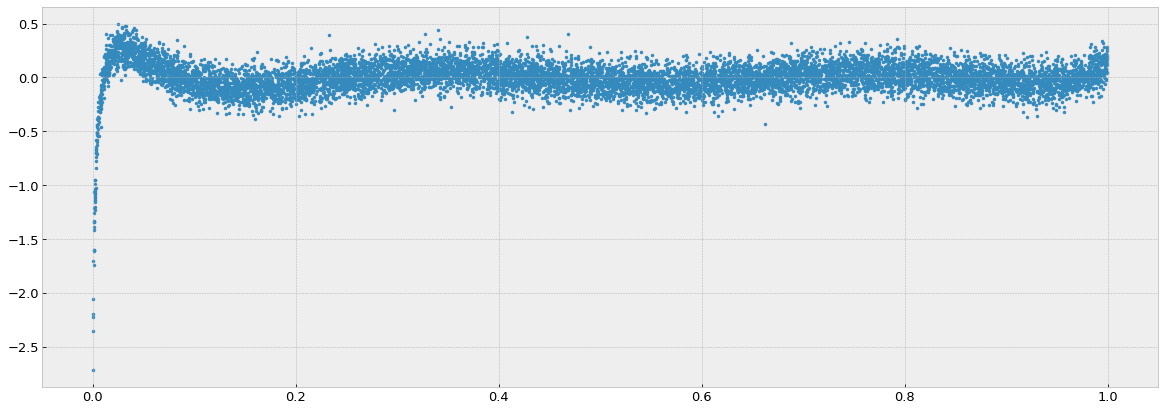

In [76]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')


n = 10_000
X1 = np.random.uniform(size=((n,1)))
y = -5 + -4*X1[:,[0]]**(1/2)+ 2*X1[:,[0]] + -3*X1[:,[0]]**2 + np.log(X1[:,[0]]) + np.random.normal(scale=.1, size=(n,1))

def getX(X1):
    degree = 6
    X = np.ones((X1.shape[0],1))
    for d in range(1,degree+1):
        # print(d)
        X = np.concatenate((X, X1**d), axis=1)
    return X

X = getX(X1)
b = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)),X.T), y)
b = np.linalg.inv(X.T@X)@X.T@y
print(f"""
b = {b.T}
mse: {((y -X@b)**2).mean():e}
mae: {np.abs(y -X@b).mean():e}
----------------------------------------------------------------
""")

# X1_ = np.linspace(0,1,(1000)).reshape(-1,1)
# X_ = getX(X1_)
# print(X_.shape)

y_hat = X@b
print(y_hat.shape)

plt.scatter(x=X1[:,0], y=y[:,0], marker='.')
plt.scatter(X1, y_hat)
plt.show()

plt.scatter(x=X1[:,0], y=y[:,0]-y_hat[:,0], marker='.')

[[1.00000000e+00 3.62695239e-01 1.31547837e-01 4.77117740e-02]
 [1.00000000e+00 4.99842368e-01 2.49842393e-01 1.24881813e-01]
 [1.00000000e+00 1.60058153e-01 2.56186122e-02 4.10046774e-03]
 ...
 [1.00000000e+00 9.19214272e-01 8.44954878e-01 7.76694583e-01]
 [1.00000000e+00 2.12318306e-01 4.50790632e-02 9.57111036e-03]
 [1.00000000e+00 3.43811333e-02 1.18206233e-03 4.06406424e-05]] (10000, 4)
[[-5.03021185]
 [ 2.43239124]
 [-3.99032812]
 [ 0.57270112]]
(10000, 1)
mae: -2.599521e-14


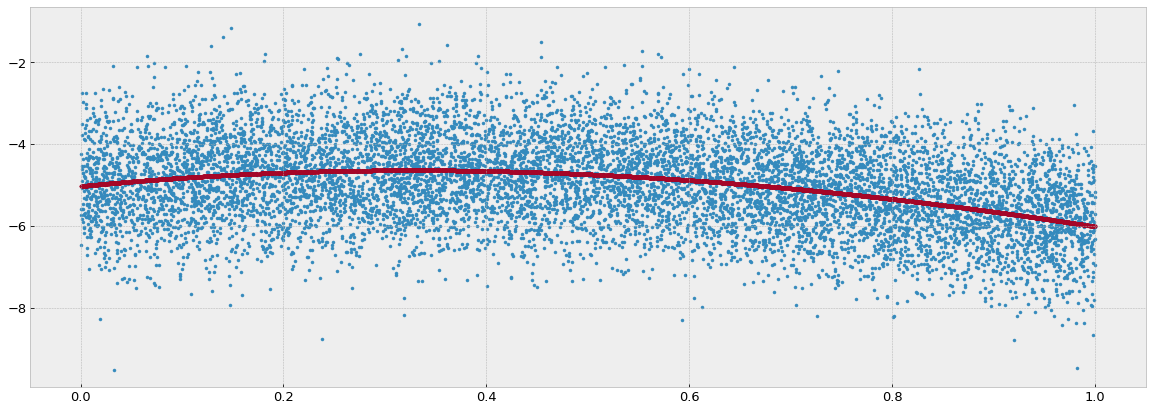

In [10]:
from numpy.linalg import inv

n = 10_000
X = np.random.uniform(size=((n,1)))
y = -5 + 2*X[:,[0]] + -3*X[:,[0]]**2 +  np.random.normal(size=(n,1))


# x**0 , x**1 , x**2 , x**3 + np.log(x) , 
degrees = 4
w = np.random.normal(scale=.02, size=degrees)
# kernel = lambda x : np.concatenate([np.ones_like(x), np.concatenate([(1/(1+np.exp(-x*w[_idx]))) for _idx in range(degrees)], axis=1)], axis=1)
kernel = lambda x : np.concatenate([x**_idx for _idx in range(degrees)], axis=1)

lam = .00
K = kernel(X)
print(K, K.shape)
b = inv(K.T@K - lam*np.identity(K.shape[1]) ) @ (K.T@y)
print(b)

y_hat = K@b
print(y_hat.shape)
print(f'mae: {(y_hat-y).mean():e}')

plt.scatter(X[:,0], y[:,0], marker='.')
plt.scatter(X[:,0], y_hat[:,0], marker='.')


# Kernel Ridge Regression

In [1]:
import numpy as np

class KernelRidgeRegression:
    def __init__(self, alpha=1.0, gamma=None):
        self.alpha = alpha
        self.gamma = gamma
        self.X_train = None
        self.alpha_coeffs = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        n_samples = X_train.shape[0]

        # Compute kernel matrix
        K = self._compute_rbf_kernel_matrix(X_train, X_train)

        # Add regularization term
        K[np.diag_indices_from(K)] += self.alpha

        # Solve the linear system
        self.alpha_coeffs = np.linalg.solve(K, y_train)

    def predict(self, X_test):
        # Compute kernel matrix between test and train data
        K_test = self._compute_rbf_kernel_matrix(X_test, self.X_train)

        # Compute predictions
        y_pred = np.dot(K_test, self.alpha_coeffs)
        return y_pred

    def _compute_rbf_kernel_matrix(self, X1, X2):
        if self.gamma is None:
            self.gamma = 1 / X1.shape[1]
        pairwise_sq_dists = np.sum((X1[:, np.newaxis] - X2[np.newaxis, :]) ** 2, axis=2)
        K = np.exp(-self.gamma * pairwise_sq_dists)
        return K



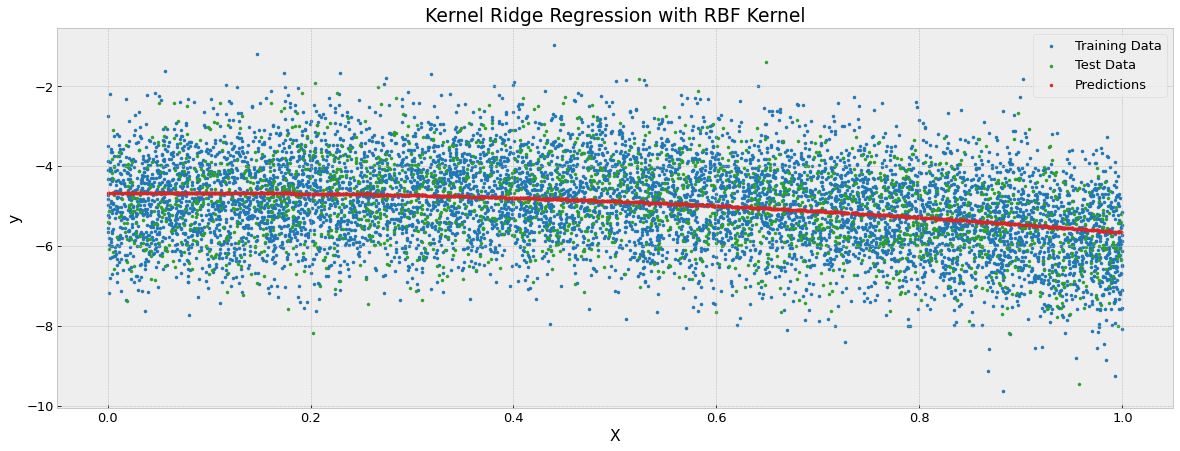

R-squared score: 0.09851284919953462


(-5.684341886080802e-16, 1.1101925775529158)

In [8]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')
# Generate synthetic dataset
# X, y = make_regression(n_samples=10000, n_features=1, noise=10, random_state=42)

# My version:
n = 10_000
X = np.random.uniform(size=((n,1)))
y = -5 + 2*X[:,[0]] + -3*X[:,[0]]**2 +  np.random.normal(size=(n,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate KernelRidgeRegression with RBF kernel
krr = KernelRidgeRegression(alpha=1.0, gamma=0.1)

# Fit the model
krr.fit(X_train, y_train)

# Predict on test data
y_pred = krr.predict(X_test)

# Compute R-squared score
y_mean = np.mean(y_test)
ss_total = np.sum((y_test - y_mean) ** 2)
ss_residual = np.sum((y_test - y_pred) ** 2)
r2_score = 1 - ss_residual / ss_total

# Plot the results
plt.scatter(X_train, y_train, color='tab:blue', label='Training Data', marker='.')
plt.scatter(X_test, y_test, color='tab:green', label='Test Data', marker='.')
plt.scatter(X_test, y_pred, color='tab:red', label='Predictions', marker='.')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Kernel Ridge Regression with RBF Kernel')
plt.legend()
plt.show()

print('R-squared score:', r2_score)
(y_test - y_mean).mean(), ((y_test - y_mean)**2).mean()


In [170]:
n = 50
X = np.random.uniform(size=((n,1)))
y = -5 + -4*X[:,[0]]**(1/2)+ 2*X[:,[0]] + -3*X[:,[0]]**2 + np.log(X[:,[0]]) + np.random.normal(scale=.1, size=(n,1))

kernel = lambda X : np.exp(-.5*X**2)
K = kernel((X-X.T))

a = inv(K + lam*np.identity(K.shape[1]))@y


# Laplace Approximation 

In [38]:
from sklearn.datasets import make_blobs
import numpy as np
X, y = make_blobs(n_samples=100, centers=2, n_features=2,
                  random_state=42, cluster_std=6)

In [39]:
def log_posterior(w, y, X):
    N = len(w)
    w_p = np.zeros(N)
    w_prior_covariance = np.eye(N)
    y_hat = 1/(1 + np.exp(-X.dot(w))) 
    prior = 0.5 * (w - w_p).dot(np.linalg.inv(w_prior_covariance)).dot(w - w_p)
    likelihood = np.sum(y * np.log(y_hat) + (1-y)*np.log(1-y_hat))
    return prior - likelihood

In [40]:
def laplace_approx(w, w_map, H):
    detH =  np.linalg.det(H)
    constant = np.sqrt(detH)/(2*np.pi)**(2.0/2.0)
    density = np.exp(-0.5 * (w-w_map).dot(H).dot(w-w_map))
    return constant * density

In [41]:
import scipy.optimize
w_0 = np.ones(2) # initial guess
solution = scipy.optimize.minimize(log_posterior, w_0, args=(y, X), method='BFGS')
w_map = solution.x
hessian = np.linalg.inv(solution.hess_inv)

/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_16513/3033988726.py:7: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(y * np.log(y_hat) + (1-y)*np.log(1-y_hat))
/Users/alexanderithakis/miniforge3/envs/QF/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_16513/3033988726.py:7: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(y * np.log(y_hat) + (1-y)*np.log(1-y_hat))


/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_16513/3033988726.py:7: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(y * np.log(y_hat) + (1-y)*np.log(1-y_hat))
/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_16513/3033988726.py:7: RuntimeWarning: invalid value encountered in multiply
  likelihood = np.sum(y * np.log(y_hat) + (1-y)*np.log(1-y_hat))
/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_16513/3168579109.py:10: RuntimeWarning: divide by zero encountered in log
  neg_log_laplace = -np.log(laplace_surface[3])


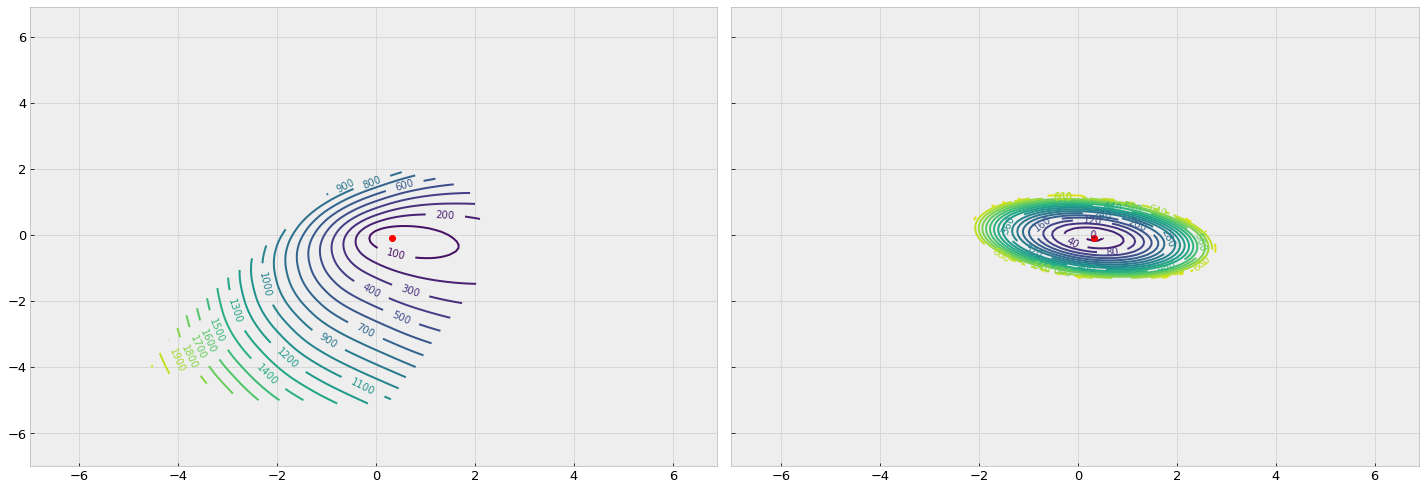

In [42]:
# Let's evalaute the posterior over a grid 
rranges = (slice(-7, 7, 0.1), slice(-7, 7, 0.1))
grid_sol = scipy.optimize.brute(log_posterior, rranges, args=(y, X),
                                full_output=True)
# pull out components
w_i0, w_i1, log_posterior_surface = grid_sol[2][0], grid_sol[2][1],  grid_sol[3]
# we'll do the same for the laplace approximation
laplace_surface = scipy.optimize.brute(laplace_approx, rranges, args=(w_map, hessian),
                                       full_output=True)
neg_log_laplace = -np.log(laplace_surface[3])

# plot surface of the model
fig, ax = plt.subplots(1,2, sharey=True)
CS = ax[0].contour(w_i0, w_i1, log_posterior_surface, cmap='viridis', levels=20)
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].plot(w_map[0], w_map[1], 'ro')
CS = ax[1].contour(w_i0, w_i1, neg_log_laplace, cmap='viridis', levels=20)
ax[1].clabel(CS, inline=1, fontsize=10)
ax[1].plot(w_map[0], w_map[1], 'ro')
plt.tight_layout()

In [48]:
import numpy as np
from scipy.optimize import minimize

def mle(data):
    def log_likelihood(theta, data):
        mu, sigma = theta
        n = len(data)
        log_like = -n/2*np.log(2*np.pi*sigma**2) - 1/(2*sigma**2)*np.sum((data-mu)**2)
        return -log_like

    mu_init = np.mean(data)
    sigma_init = np.std(data)
    theta_init = [mu_init, sigma_init]
    res = minimize(log_likelihood, theta_init, args=(data,), method='Nelder-Mead')
    return res.x

data = np.random.choice([0,1], size=10, replace=True, p=[.4, .6])
data = np.random.poisson(1, size=10)

print(mle(data))
data, data.mean(), data.std()

[0.9        0.94339811]


(array([2, 0, 2, 1, 0, 0, 2, 2, 0, 0]), 0.9, 0.9433981132056605)